# PRÀCTICA 1: Identificació d'idioma

En la pràctica proposat es demana la creació de models de llenguatge per la identificació d'idioma. Les dades que s'utilitzen per modelitzar són de wortschatz leipzig corpora on hi ha un document txt de training formada per 30k frases i un de test formada per 10k frases per cadascuna de les 6 llengües (anglès, castellà, neerlandès, alemany, italià i fracès).
El model de llenguatge utilitza trigrams de caràcters i s'empra la tècnica de suavitzat o smoothing.

Primer de tot, s'importen les llibreries que es faran servir en el preprocessing i en la modelització.

In [1]:
import nltk
import re
from nltk.collocations import TrigramCollocationFinder
from math import log
from copy import deepcopy
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score

## Importar les dades

Tal com ja s'ha dit, hi ha 6 documents de training i 6 de test de les diferents llengües. Aquí s'especifica el contingut corresponent al nom del document dins l'arxiu:
- 'deu_trn.txt': dades (textuals) d'entrenament alemany.
- 'eng_trn.txt': dades (textuals) d'entrenament anglès.
- 'fra_trn.txt': dades (textuals) d'entrenament francès.
- 'ita_trn.txt': dades (textuals) d'entrenament italià.
- 'nld_trn.txt': dades (textuals) d'entrenament neerlandès.
- 'spa_trn.txt': dades (textuals) d'entrenament castellà.
- 'deu_tst.txt': dades (textuals) de test alemany.
- 'eng_tst.txt': dades (textuals) de test anglès.
- 'fra_tst.txt': dades (textuals) de test francès.
- 'ita_tst.txt': dades (textuals) de test italià.
- 'nld_tst.txt': dades (textuals) de test neerlandès.
- 'spa_tst.txt': dades (textuals) de test castellà.

Es creen dues variables 'train_set' i 'test_set' per guardar les dades. Cada element de la llista correspon a les dades textuals d'un idioma.

In [2]:
train_list = ["deu_trn.txt", "eng_trn.txt", "fra_trn.txt", "ita_trn.txt", "nld_trn.txt", "spa_trn.txt"]
test_list = ["deu_tst.txt", "eng_tst.txt", "fra_tst.txt", "ita_tst.txt", "nld_tst.txt", "spa_tst.txt"]

num_languages = len(train_list)

train_set = []
test_set = []

for txt in train_list:
    with open(txt, "r", encoding="utf-8") as archive:
        content = archive.read()
        train_set.append(content)

for txt in test_list:
    with open(txt, "r", encoding="utf-8") as archive:
        content = archive.read()
        test_set.append(content)

In [3]:
print(train_set[1])

1	• • •
2	0.00 0.00% How the mighty have fallen.
3	0.00 0.00% Major companies coming out with their latest quarterly numbers include Dave & Buster's, Men's Wearhouse, Palo Alto Networks, Box, Barnes & Noble, Pep Boys-Manny, Moe & Jack, Ollie's Bargain Outlet, DavidsTea, Lululemon Athletica and Kroger.
4	01 JANUARY 2015, MAGAZINE Why are there so many Magna Cartas?
5	0:44 Now watching Up next 2016 Word Association with Brad Woodhouse The president of the Democratic American Bridge PAC on the GOP presidential field.
6	0:46 autoplay autoplay Copy this code to your website or blog Searchers have found a second body in the aftermath of a large landslide in Sitka, Alaska, authorities said Thursday, and a third man remains missing and presumed dead.
7	07:33: Building success The construction industry experienced an "extremely successful" end to 2014, according to a business survey.
8	08:16: Milk crisis BBC Radio 4 National Farmers Union (NFU) president Meurig Raymond tells Today the latest cr

## PREPROCESSING

Pel bon funcionament en la part de modelització, cal preprocessar les dades de manera acurada. Pel tractament dels texts s'utilitza la llibreria 'regular expression' de python i es realitza amb els següets passos:

### Eliminar els dígits del text 

Els dígits amplien la mida de les dades sense aportar informació per diferenciar les 6 llengües, és per això que s'eliminen

In [4]:
for i, txt in enumerate(train_set):
    train_set[i] = re.sub(r'\d+', '', txt)

### Convertir tot el text a minúscula

Per poder detectar els patrons de les llengües i reduir-ne la dimensionalitat, es converteix tot el text en minúscula. Així, s'evita el problema de que "Hola" i "hola" es considerin com paraules diferents.

In [5]:
for i, txt in enumerate(train_set):
    train_set[i] = txt.lower()

In [6]:
print(train_set[1])

	• • •
	. .% how the mighty have fallen.
	. .% major companies coming out with their latest quarterly numbers include dave & buster's, men's wearhouse, palo alto networks, box, barnes & noble, pep boys-manny, moe & jack, ollie's bargain outlet, davidstea, lululemon athletica and kroger.
	 january , magazine why are there so many magna cartas?
	: now watching up next  word association with brad woodhouse the president of the democratic american bridge pac on the gop presidential field.
	: autoplay autoplay copy this code to your website or blog searchers have found a second body in the aftermath of a large landslide in sitka, alaska, authorities said thursday, and a third man remains missing and presumed dead.
	:: building success the construction industry experienced an "extremely successful" end to , according to a business survey.
	:: milk crisis bbc radio  national farmers union (nfu) president meurig raymond tells today the latest crisis at first milk is just a symptom of a much wi

### Substituir els espais en blanc continus per un de sol

Els espais en blanc, tabuladors, salts de línia... no són gaire significants en la modelització basat en trigrames de caràcters. Com que no es té en compte la semàntica, la intenció del text ni l'estructura global, es substitueixen per un sol espai en blanc.

In [7]:
for i, txt in enumerate(train_set):
    train_set[i] = re.sub(r'\s+', ' ', txt)

In [8]:
print(train_set[5][:9999])

 denuncia iem probable fraude con actas electorales el instituto electoral de michoacán denunció ante la fiscalía especializada la presencia de actas de escrutinio y cómputo, al parecer apócrifas, en un taller de impresión ricardo. a pesar de la organización del movimiento, su paisano, abelande, critica la dispersión de las propuestas. es decir, el bm entrega préstamos (evidentemente con elevados intereses que engrosan la deuda externa letal de los estados) a condición del cumplimiento de sus programas de ajuste estructural. sin embargo, el juego no tenía construida una buena lan. buscados por las autoridades, trabajamos en secreto. "cuando empezamos no teníamos ni libros ni clientes: los libros aún no existían, y los clientes estaban en el armario", bromea. el compromiso llegó el pasado enero, cuando anunciaron la fecha de la boda en argentina y el deseo de formar "una gran familia". las “habú” adultas suelen alcanzar unos , metros. "preferiríamos morir a renunciar a nuestro estilo de

### Concatenar totes les frases amb un espai doble al mig

Una manera de permetre la identificació d'un final o inici de frase, en aquest cas, és mitjançant la concatenació de frases amb espai doble al mig. Això és degut a què el model és basat en trigrames de caràcters. Per tant, l'estructura obliga a què el trigrama de final de frase sigui "(.,_,_)" i el d'un inici de frase, "(_,_,(Majúscula))".

S'utilitza NLTK per la divisió de les frases. Dins del paràmetre 'language', s'hi posa el llenguatge corresponent al text. Després, es concatena les frases amb un doble espai al mig.

In [9]:
nltk.download('punkt')
idiomas = ['german','english','french','italian','dutch','spanish']
for i,idioma in enumerate(idiomas):
    frases = nltk.sent_tokenize(train_set[i], language=idioma)
    train_set[i] = '  '.join(frases)

[nltk_data] Downloading package punkt to C:\Users\Zhihao
[nltk_data]     Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_set[3][800:9999]

'ità bettole) fino all\'innesto della sp , a partire da un\'ora prima del passaggio del primo ciclista secondo la media più veloce della cronotabella.  chiunque è in grado di leggere e verificare".  schierato in gp series nel e nel nell\'ambito del programma di development renault, il promettente "pechito" è stato tester della squadra francese in f per il .  negli ultimi due anni ha vinto a mani basse il campionato turismo .  i rappresentanti dei lavoratori, che per il percepiranno un sussidio minimo di euro mensili, hanno sollecitato un&rsquo;integrazione al reddito e misure di reinserimento occupazionale.  vittoria del deportivo la coruna sullo xerez, maiorca-siviglia è in corso dalle .  "il problema - ha sottolineato - non è un contratto, non sarà mai un contratto.  roma - una festa di compleanno tra romeni si e\' trasformata in una violenta rissa finche\' la situazione non e\' degenerata ed uno dei partecipanti ha estratto il coltello ferendo il rivale ed uccidendolo.  posso pagare

### Preprocessing en el conjunt de test

Per tal de mantenir la consistència en la representació de les dades, cal aplicar els mateixos passos de preprocessament al conjunt de test

In [11]:
#Eliminar digits
for i, txt in enumerate(test_set):
    test_set[i] = re.sub(r'\d+', '', txt)

#Minúscula
for i, txt in enumerate(test_set):
    test_set[i] = txt.lower()

#Substituir espais en blanc continus per un de sol
for i, txt in enumerate(test_set):
    test_set[i] = re.sub(r'\s+', ' ', txt)

#Concatenar totes les frases amb un espai dobre al mig
idiomas = ['german','english','french','italian','dutch','spanish']
for i,idioma in enumerate(idiomas):
    frases = nltk.sent_tokenize(test_set[i], language=idioma)
    test_set[i] = '  '.join(frases)

## Definició dels models

Per l'entrenament dels models, s'ha creat una classe que agafa com a arguments el valor de lambda i el nombre d'unigrames potencialment observables.
- El mètode "fit" troba tots els trigrames de caràcters del text del paràmetre que tingui una freqüència igual o superior a 5. A més, crida al mètode "_calculate_N" per obtenir el nombre d'ocurrències de trigrames.
- El mètode "transform" crida al mètode "_compute_prob" per obtenir la probabilitat, per cada frase de les dades test, de ser de l'idioma en que s'ha entrenat el model.
- El mètode "set_lamb" canvia el valor de la variable d'instància "lambda", cosa que serà útil més tard per entrenar els models.
- El mètode "_calculate_N" calcula el nombre d'ocurrpencies de trigrames en les dades.
- El mètode "_compute_prob" calcula la probabilitat, per cada frase de les dades test, de ser de l'idioma en que s'ha entrenat el model.

'B' (nombre d'unigrames potencialment observables) és un paràmtre que caldria estimar. Com que les dades proporcionades són de mida prou gran, amb 30k paraules en el train i 10k paraules en el test, 'B' es podria estimar a partir d'aquestes. Cal tenir en compte que s'ha d'utilitzar tots els 6 tests encara que no siguin de l'idioma corresponent al model perquè sinó, amb només el test de la llengua, s'estaria afegint informació de la correspondència.
La classe Model, per defecte, calcula la 'B' tal com s'ha dit anteriorment, però també permet rebre un valor d'aquest com a paràmetre. Es podria definir la cota superior com el nombre de lletres més el nombre de lletres amb accents més el nombre de símbols tot elevat al cub (aproximadament (27+5+10)^3). Aleshores, es té que:
- B1 és la obtinguda a partir de les dades de train i tests
- B2 és la cota superior

In [12]:
class Model():
    def __init__(self, lamb = 0.5, B = None):
        self.lamb = lamb
        self.B = B
        self.test_trig = None
    
    def fit(self, train_set):
        finder = TrigramCollocationFinder.from_words(train_set)
        finder.apply_freq_filter(5)
        self.trigram_freq = finder.ngram_fd
        self._calculate_N()
        self._calculate_B()

    def transform(self, test_txt):
        prob = self._compute_prob(test_txt)
        return prob
    
    def set_lamb(self, lamb):
        self.lamb = lamb
    
    def _calculate_N(self):
        self.N = sum(self.trigram_freq.values())
    
    def _calculate_B(self):
        if self.B == None:
            if self.test_trig == None:
                text = test_set+[]
                f = []
                for t in text:
                    finder = TrigramCollocationFinder.from_words(t)
                    f += finder.ngram_fd
                self.test_trig = set(f)
            finder = TrigramCollocationFinder.from_words(train_set)
            f2 = set(finder.ngram_fd)
            self.B = len(f2.union(self.test_trig))
    
    def _compute_prob(self, test_txt):
        test = deepcopy(test_txt)
        for i, sent in enumerate(test):
            for trigram in sent.keys():
                if trigram in self.trigram_freq:
                    c = self.trigram_freq[trigram]
                else:
                    c = 0
                test[i][trigram] = log((c+self.lamb)/(self.N + self.lamb*self.B))
        for i, sent in enumerate(test):
            test[i] = sum(sent.values())
        return test

### Entrenament dels models

La funció "sentence_split" permet, donat un text, separar el text per oracions (amb l'idioma que vé per defecte, que és anglès) i tokenitzar cada oració del text.

In [13]:
def sentence_split(txt):
    splited = nltk.sent_tokenize(txt)
    for j, sent in enumerate(splited):
        finder = TrigramCollocationFinder.from_words(sent)
        splited[j] = finder.ngram_fd #una lista de dicc, cada dicc es una oracion
    return splited

La classe "Result" permet guardar el resultat, cal rebre dos paràmetres a l'hora d'inicialitzar: "models" és una llista de models de llenguatge i "test_set_splited" és el text de input dels models, de manera que ha d'estar separat per oracions i tokenitzat. En inicialitzar, els models rep com a entreda del "test_set_splited" i realitza un "transform" sobre ell per obtenir el resultat de classificació de les instàncies.
Els mètodes de la classe són: "scores" per obtenir l'exactitud i la precisió de la classificació i "conf_matrix" per dibuixar la matriu de confusió. També es pot veure la probabilitat de pertànyer al llenguatge de cada model cridant a la variable d'instància "df", on cada fila és una oració i hi ha 6 columnes en què cada una correspon a la probabilitat computada per cada model. 

In [14]:
class Result():
    
    def __init__(self, models, test_set_splited):
        self.probs = dict()
        self.probs['real'] = []
        self.probs['predicted'] = []
        self.models = models
        self.num_languages = len(test_set_splited)
        self._create_df(test_set_splited)

    def scores(self):
        self.acc = accuracy_score(self.df['real'], self.df['predicted'])
        self.prec = precision_score(self.df['real'], self.df['predicted'], average=None).mean()
        return (self.acc, self.prec)

    def conf_matrix(self):
        self.matrix = confusion_matrix(self.df['real'], self.df['predicted'])
        disp = ConfusionMatrixDisplay(self.matrix)
        disp.plot() 

    def _compute_total_prob(self, test_set_splited):
        for i in range(self.num_languages):
            self.probs[f'model_{i+1}'] = []
            prob = []
            for j, test_text in enumerate(test_set_splited):
                prob = self.models[i].transform(test_text)
                self.probs[f'model_{i+1}'] += prob
                if i == 0:
                    self.probs['real'] += [j+1 for _ in range(len(prob))]

        self.num_sents = len(self.probs['real'])

    def _final_pred(self):
        for sent in range(self.num_sents):
            max = float('-inf')
            for i in range(self.num_languages):
                model = f'model_{i+1}'
                value = self.probs[model][sent]
                if value > max:
                    max = value
                    pos = i+1
            self.probs['predicted'] += [pos]

    def _create_df(self, test_set_splited):
        self._compute_total_prob(test_set_splited)
        self._final_pred()
        self.df = pd.DataFrame(self.probs)


La funció "find_best" permet trobar el millor hiperparàmetre dels models (lambda) donada una llista de valors de lambdas, assumint que tots els models tenen el mateix valor de lambda per simplicitat. Retorna dos variables, la primera és la instància de "Resultat" on s'ha fet servir el millor valor de lambda, i la segona és el valor del millor lambda. La funció rep un argument anomenat "scoring", que és el criteri de valoració dels models, pot ser o bé "accuracy" o bé "precision".

In [15]:
def find_best(models, txt_set_splited, lamb_list, scoring):
    acc_list = []
    pre_list = []
    mod_list = []
    for lamb in lamb_list:
        for model in models:
            model.set_lamb(lamb)
        result = Result(models, txt_set_splited)
        scores = result.scores()
        acc_list.append(scores[0])
        pre_list.append(scores[1])
        mod_list.append(result)
    if scoring == "accuracy":
        max_acc = max(acc_list)
        best_l = lamb_list[acc_list.index(max_acc)]
        best_m = mod_list[acc_list.index(max_acc)]
    elif scoring == "precision":
        max_pre = max(pre_list)
        best_l = lamb_list[pre_list.index(max_pre)]
        best_m = mod_list[pre_list.index(max_pre)]

    return best_m, best_l


In [16]:
models = [Model() for _ in range(num_languages)]
for i in range(num_languages):
    models[i].fit(train_set[i])

In [17]:
test_set_splited = []
for test in test_set:
    test_set_splited.append(sentence_split(test))

In [18]:
lambdas = [0.25, 0.5, 0.75]
best_model, best_lambda = find_best(models, test_set_splited, lambdas, "accuracy")

### Inferència

Es veu que el millor valor de lambda és 0.5

In [19]:
best_lambda

0.5

In [20]:
result = best_model

In [21]:
result.df

real  predicted      model_1      model_2      model_3      model_4  \
0         1          1 -1955.016825 -2298.965670 -2375.389406 -2463.117296   
1         1          1 -1170.175605 -1429.407047 -1479.259374 -1550.038549   
2         1          1  -999.021122 -1090.180564 -1146.897862 -1205.512535   
3         1          1 -1200.303104 -1365.901466 -1427.228776 -1480.517749   
4         1          1 -1056.420542 -1286.003461 -1347.011192 -1393.272622   
...     ...        ...          ...          ...          ...          ...   
62481     6          1     0.000000     0.000000     0.000000     0.000000   
62482     6          6 -1002.314378  -909.792483  -911.196445  -890.388982   
62483     6          6  -298.891100  -295.377669  -299.099781  -281.195213   
62484     6          1     0.000000     0.000000     0.000000     0.000000   
62485     6          6 -2092.463978 -1957.372380 -1944.904068 -1890.358934   

           model_5      model_6  
0     -2180.767363 -2513.873865  
1     -1308.193057 -1534.048475  
2     -1097.058141 -1193.801130  
3     -1295.856610 -1502.667742  
4     -1209.599200 -1398.957940  
...            ...          ...  
62481     0.000000     0.000000  
62482  -975.275965  -752.731551  
62483  -302.940067  -235.336349  
62484     0.000000     0.000000  
62485 -2039.615034 -1575.927307  

[62486 rows x 8 columns]

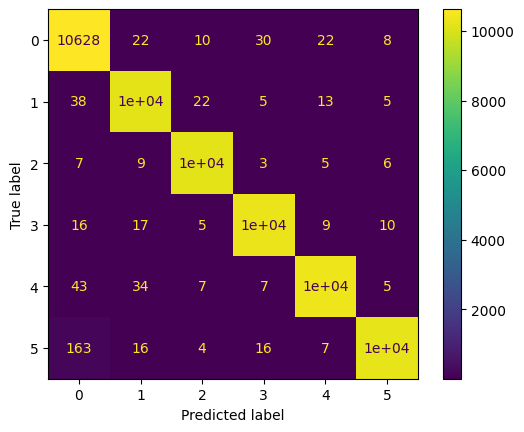

In [22]:
result.conf_matrix()

In [23]:
scores = result.scores()
print('Accuracy:', scores[0], 'Precision:', scores[1])

Accuracy: 0.9909739781711103 Precision: 0.9911195773610872


La classificació té una exactitud i una precisió extremadament alta, en la majoria de casos classifica correctament! 

### Model 2

En el model 2, la 'B' s'utilitza la B2 que és la cota superior com ja s'ha dit anteriorment. Com que és un valor precalculat, l'execució és més ràpida.

In [24]:
b = (27+5+10)**3
models_B2 = [Model(B=b) for _ in range(num_languages)]
for i in range(num_languages):
    models_B2[i].fit(train_set[i])

In [25]:
test_set_splited = []
for test in test_set:
    test_set_splited.append(sentence_split(test))

lambdas = [0.25, 0.5, 0.75]
best_model, best_lambda = find_best(models_B2, test_set_splited, lambdas, "accuracy")

Com en el cas anterior, la millor lambda és 0.5

In [26]:
best_lambda

0.5

In [27]:
result = best_model
result.df

real  predicted      model_1      model_2      model_3      model_4  \
0         1          1 -1956.389892 -2300.251256 -2376.654287 -2464.338346   
1         1          1 -1171.049909 -1430.225647 -1480.064789 -1550.816055   
2         1          1  -999.731127 -1090.845333 -1147.551924 -1206.143933   
3         1          1 -1201.171540 -1366.714572 -1428.028785 -1481.290037   
4         1          1 -1057.200961 -1286.734158 -1347.730119 -1393.966638   
...     ...        ...          ...          ...          ...          ...   
62481     6          1     0.000000     0.000000     0.000000     0.000000   
62482     6          6 -1002.907027  -910.347373  -911.742397  -890.916016   
62483     6          6  -299.108209  -295.580946  -299.299783  -281.388285   
62484     6          1     0.000000     0.000000     0.000000     0.000000   
62485     6          6 -2093.719689 -1958.548087 -1946.060839 -1891.475620   

           model_5      model_6  
0     -2182.241468 -2515.053566  
1     -1309.131696 -1534.799652  
2     -1097.820392 -1194.411146  
3     -1296.788949 -1503.413878  
4     -1210.437046 -1399.628453  
...            ...          ...  
62481     0.000000     0.000000  
62482  -975.912224  -753.240738  
62483  -303.173152  -235.522883  
62484     0.000000     0.000000  
62485 -2040.963146 -1577.006179  

[62486 rows x 8 columns]

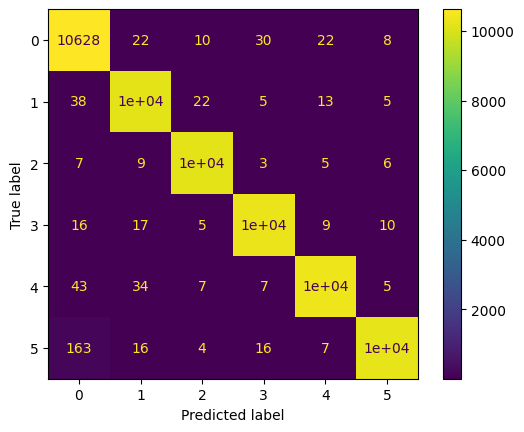

In [28]:
result.conf_matrix()

In [29]:
scores = result.scores()
print('Accuracy:', scores[0], 'Precision:', scores[1])

Accuracy: 0.9909739781711103 Precision: 0.9911195773610872


## Conclusió

En tots dos casos (model B1 i model B2) es pot observar que, tant per l'exactitud com per la precisió, els valors són extremadament alts i semblants. Això demostra que els models són capaços de predir correctament l'idioma en què està escrit el textos en la gran majoria de casos. A més, comprova que el càlcul de B1 pot representar aproximadament al valor B real.
Durant la modelització, s'ha trobat que, pels dos models funcionen millor prenent lambda com a 0.5. En les matrius de confussions, s'observa un nombre molt significant a la diagonal que ja té sentit pels resultats obtinguts. També es veu que, encara que comparat amb les prediccions correctes és molt insignificant, hi ha tendència a predir com a alemany els que no ho són. Sembla que textos en castellà són les que causen més error de predicció a l'alemany.